# Taxi Data Exploration

#### Import packages and spark session

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.window import Window as Window

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
spark = SparkSession.builder.appName('arjun-eda').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

In [5]:
spark

### Import data and union

In [6]:
df_2018 = spark.read.csv("gs://big_data_taxi/taxi-data/taxi_2018.csv", inferSchema=True, header=True)
df_2019 = spark.read.csv("gs://big_data_taxi/taxi-data/taxi_2019.csv", inferSchema=True, header=True)
df_2020 = spark.read.csv("gs://big_data_taxi/taxi-data/taxi_2020.csv", inferSchema=True, header=True)
df_2021 = spark.read.csv("gs://big_data_taxi/taxi-data/taxi_2021.csv", inferSchema=True, header=True)
df_2022 = spark.read.csv("gs://big_data_taxi/taxi-data/taxi_2022.csv", inferSchema=True, header=True)

In [7]:
df_taxi = df_2018.union(df_2019).union(df_2020).union(df_2021).union(df_2022)

### Initial exploration and data cleaning

Start off by just taking a look at the schema, dtypes, missing values etc.

In [8]:
df_taxi.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

In [13]:
df_taxi.count()

46759676

In [9]:
df_taxi.show(2, vertical = True)

-RECORD 0------------------------------------------
 Trip ID                    | f24ef1302cd672bbc... 
 Taxi ID                    | 1801165e22d31b0d2... 
 Trip Start Timestamp       | 01/01/2019 12:00:... 
 Trip End Timestamp         | 01/01/2019 12:15:... 
 Trip Seconds               | 885                  
 Trip Miles                 | 3.45                 
 Pickup Census Tract        | null                 
 Dropoff Census Tract       | null                 
 Pickup Community Area      | null                 
 Dropoff Community Area     | null                 
 Fare                       | 12.75                
 Tips                       | 0.0                  
 Tolls                      | 0.0                  
 Extras                     | 4.0                  
 Trip Total                 | 16.75                
 Payment Type               | Cash                 
 Company                    | Flash Cab            
 Pickup Centroid Latitude   | null                 
 Pickup Cent

In [23]:
df_taxi.select([count(c).alias(c) for c in df_taxi.columns]).show(vertical = True)

-RECORD 0------------------------------
 Trip ID                    | 46759676 
 Taxi ID                    | 46759676 
 Trip Start Timestamp       | 46759676 
 Trip End Timestamp         | 46757402 
 Trip Seconds               | 46750901 
 Trip Miles                 | 46757852 
 Pickup Census Tract        | 28726861 
 Dropoff Census Tract       | 28521684 
 Pickup Community Area      | 43368840 
 Dropoff Community Area     | 42203931 
 Fare                       | 46755243 
 Tips                       | 46755243 
 Tolls                      | 42296339 
 Extras                     | 46755243 
 Trip Total                 | 46755243 
 Payment Type               | 46759676 
 Company                    | 46759676 
 Pickup Centroid Latitude   | 43378317 
 Pickup Centroid Longitude  | 43378317 
 Pickup Centroid Location   | 43378317 
 Dropoff Centroid Latitude  | 42362023 
 Dropoff Centroid Longitude | 42362023 
 Dropoff Centroid  Location | 42362023 



Data is fairly populated, other than some of the centroid and census tract data. We probably won't use these anyway so can drop those

Next drop some of the extraneous columns, and change some dtypes to appropriate dates etc.

In [7]:
df_taxi = df_taxi.drop('Pickup Centroid Latitude','Pickup Centroid Longitude','Pickup Centroid Location',
                      'Dropoff Centroid Latitude','Dropoff Centroid Longitude','Dropoff Centroid  Location',
                      'Pickup Census Tract', 'Dropoff Census Tract')

In [8]:
df_taxi.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)



In [9]:
df_taxi = df_taxi.withColumn('Trip Start Timestamp',F.to_timestamp(col('Trip Start Timestamp'),"MM/dd/yyyy hh:mm:ss a"))
df_taxi = df_taxi.withColumn('Trip End Timestamp',F.to_timestamp(col('Trip End Timestamp'),"MM/dd/yyyy hh:mm:ss a"))

#### Augment the data with some helper date columns and the actual community names versus the numbers

In [10]:
df_communities = spark.read.csv('gs://big_data_taxi/taxi-data/community.csv', inferSchema=True, header=True)

In [11]:
df_taxi = df_taxi.join(df_communities, df_taxi['Pickup Community Area'] == df_communities['community_id'], 
                       "left_outer")

df_taxi = df_taxi.drop('community_id').withColumnRenamed('community_name','Pickup Community Name')

In [12]:
df_taxi = df_taxi.join(df_communities, df_taxi['Dropoff Community Area'] == df_communities['community_id'], 
                       "left_outer")

df_taxi = df_taxi.drop('community_id').withColumnRenamed('community_name','Dropoff Community Name')

In [13]:
df_taxi = df_taxi.withColumn('Ride Month',F.month(col('Trip Start Timestamp')))
df_taxi = df_taxi.withColumn('Ride Year',F.year(col('Trip Start Timestamp')))
df_taxi = df_taxi.withColumn('Ride Day of Week', F.dayofweek('Trip Start Timestamp'))
df_taxi = df_taxi.withColumn('Ride Date', F.to_date('Trip Start Timestamp'))
df_taxi = df_taxi.withColumn('Ride Month Year',F.concat_ws('-',col('Ride Year'),F.lpad(col('Ride Month'),2,'0')))

In [14]:
df_taxi.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: timestamp (nullable = true)
 |-- Trip End Timestamp: timestamp (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Community Name: string (nullable = true)
 |-- Dropoff Community Name: string (nullable = true)
 |-- Ride Month: integer (nullable = true)
 |-- Ride Year: integer (nullable = true)
 |-- Ride Day of Week: integer (nullable = true)
 |-- Ride Date: date (nullable = true)
 |-- Ride Month Year: string (nullable = false)



### Now lets take a look at location frequencies in a couple different ways

#### First just look at top 10 locations overall

In [38]:
tmp_pickup = df_taxi.groupby('Pickup Community Name').count().sort('count',ascending = False).dropna().toPandas()
tmp_dropoff = df_taxi.groupby('Dropoff Community Name').count().sort('count',ascending = False).dropna().toPandas()

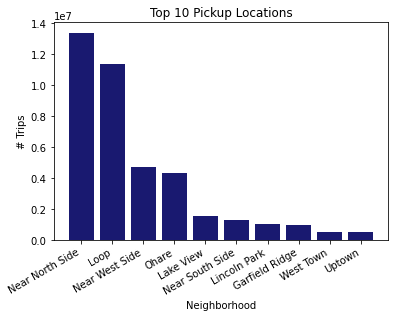

In [45]:
plt.xticks(rotation=30, ha='right')
plt.bar(tmp_pickup['Pickup Community Name'].head(10).astype(str),tmp_pickup['count'].head(10), color = 'midnightblue')
plt.title('Top 10 Pickup Locations')
plt.ylabel('# Trips')
plt.xlabel('Neighborhood')
plt.show()

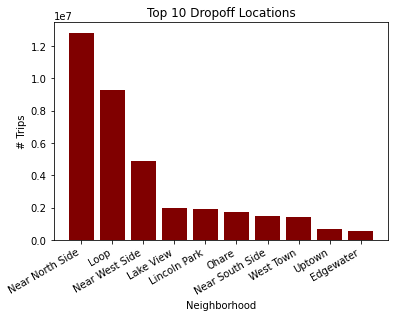

In [41]:
plt.xticks(rotation=30, ha='right')
plt.bar(tmp_dropoff['Dropoff Community Name'].head(10).astype(str),tmp_dropoff['count'].head(10),color = 'maroon')
plt.title('Top 10 Dropoff Locations')
plt.ylabel('# Trips')
plt.xlabel('Neighborhood')
plt.show()

#### Now look at if this has changed YOY

In [17]:
tmp_pickup_yoy = df_taxi.cube('Ride Year','Pickup Community Name').count()
tmp_pickup_yoy = tmp_pickup_yoy.dropna()

window = Window.orderBy(F.desc('count')).partitionBy(col('Ride Year'))
tmp_pickup_yoy = tmp_pickup_yoy.withColumn('rank',F.rank().over(window))
tmp_pickup_yoy = tmp_pickup_yoy.toPandas()

In [18]:
tmp_dropoff_yoy = df_taxi.cube('Ride Year','Dropoff Community Name').count()
tmp_dropoff_yoy = tmp_dropoff_yoy.dropna()

window = Window.orderBy(F.desc('count')).partitionBy(col('Ride Year'))
tmp_dropoff_yoy = tmp_dropoff_yoy.withColumn('rank',F.rank().over(window))
tmp_dropoff_yoy = tmp_dropoff_yoy.toPandas()

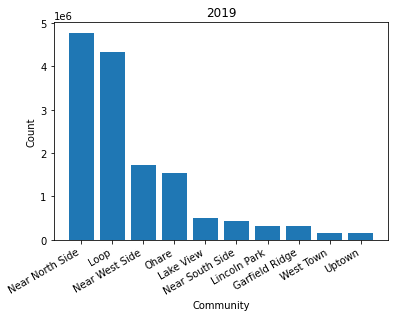

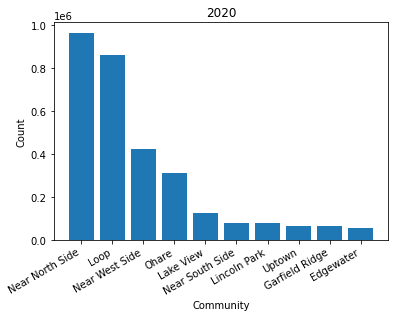

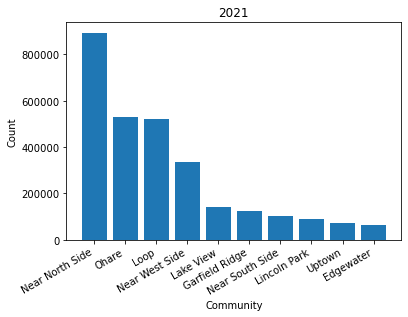

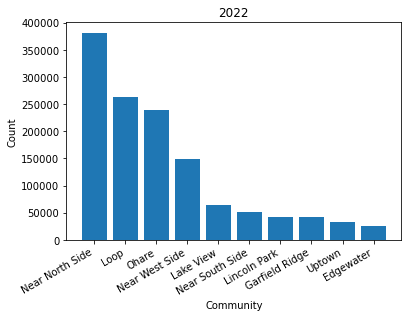

In [33]:
years = [2019,2020,2021,2022]

for i in years:
    df = tmp_pickup_yoy[(tmp_pickup_yoy['Ride Year'] == i) & (tmp_pickup_yoy['rank'] <= 10 )]
    
    x = df['Pickup Community Name']
    y = df['count']
    
    plt.title(i)
    plt.xlabel('Community')
    plt.ylabel('Count')
    plt.xticks(rotation=30, ha='right')
    plt.bar(x,y)
    plt.show()

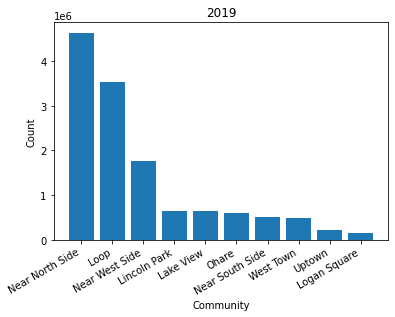

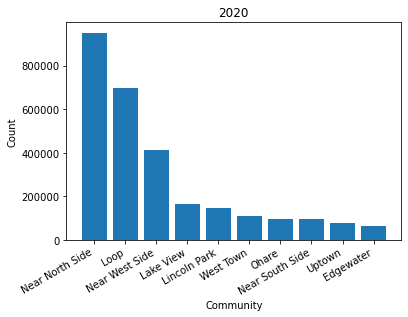

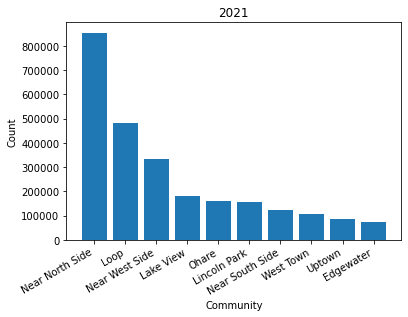

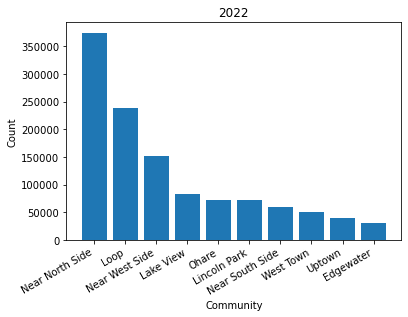

In [34]:
for i in years:
    df = tmp_dropoff_yoy[(tmp_dropoff_yoy['Ride Year'] == i) & (tmp_dropoff_yoy['rank'] <= 10 )]
    
    x = df['Dropoff Community Name']
    y = df['count']
    
    plt.title(i)
    plt.xlabel('Community')
    plt.ylabel('Count')
    plt.xticks(rotation=30, ha='right')
    plt.bar(x,y)
    plt.show()

### Create a heatmap of most common trips

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns

In [103]:
df_taxi_heatmap = df_taxi.crosstab('Pickup Community Name', 'Dropoff Community Name').toPandas()

In [104]:
df_taxi_heatmap

,Pickup Community Name_Dropoff Community Name,Albany Park,Archer Heights,Armour Square,Ashburn,Auburn Gresham,Austin,Avalon Park,Avondale,Belmont Cragin,...,Washington Park,West Elsdon,West Englewood,West Garfield Park,West Lawn,West Pullman,West Ridge,West Town,Woodlawn,null
0,North Center,2320,10,94,14,29,183,2,3005,441,...,14,5,16,18,13,10,1770,2524,45,2326
1,Near West Side,5508,772,14852,1467,5823,10363,2084,7667,2679,...,2596,581,2836,3297,713,2007,5153,165179,5306,78082
2,null,3653,432,2210,1604,1681,3992,632,2915,1584,...,598,272,939,710,1047,1583,14879,15835,1824,2812646
3,Humboldt Park,358,21,158,42,290,1259,29,612,935,...,99,20,155,392,16,86,258,4121,174,1603
4,West Garfield Park,59,9,128,65,53,593,10,46,63,...,52,5,89,1530,27,27,41,198,44,1018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Logan Square,1949,39,278,20,191,1006,61,6648,3470,...,87,45,85,200,21,13,1184,22285,230,4494
74,Archer Heights,19,1212,52,57,27,31,3,27,10,...,91,58,15,10,58,5,9,43,54,451
75,Auburn Gresham,24,13,443,592,5055,265,166,31,17,...,385,34,450,79,149,607,44,189,497,2885
76,Avalon Park,9,2,164,99,184,61,2068,18,3,...,116,8,118,17,23,157,7,55,308,1534


In [105]:
popular_neigborhoods = list(tmp_pickup['Pickup Community Name'].head(10))

In [106]:
popular_neigborhoods

['Near North Side',
 'Loop',
 'Near West Side',
 'Ohare',
 'Lake View',
 'Near South Side',
 'Lincoln Park',
 'Garfield Ridge',
 'West Town',
 'Uptown']

In [110]:
from pandas.api.types import CategoricalDtype

ordering = CategoricalDtype(popular_neigborhoods, ordered=True)
df_taxi_heatmap = df_taxi_heatmap[df_taxi_heatmap['Pickup Community Name_Dropoff Community Name'].isin(popular_neigborhoods)]
df_taxi_heatmap['Pickup Community Name_Dropoff Community Name'] = df_taxi_heatmap['Pickup Community Name_Dropoff Community Name'].astype(ordering)
df_taxi_heatmap = df_taxi_heatmap.sort_values('Pickup Community Name_Dropoff Community Name')

In [114]:
df_taxi_heatmap = df_taxi_heatmap.set_index('Pickup Community Name_Dropoff Community Name', drop = True)
df_taxi_heatmap = df_taxi_heatmap[popular_neigborhoods]

In [117]:
df_taxi_heatmap

,Near North Side,Loop,Near West Side,Ohare,Lake View,Near South Side,Lincoln Park,Garfield Ridge,West Town,Uptown
Pickup Community Name_Dropoff Community Name,,,,,,,,,,
Near North Side,5220126,3153807,1413019,461132,489849,409612,675184,133798,460971,109172
Loop,3645102,3045704,1835666,421648,309121,502946,387244,127023,308770,66754
Near West Side,1361557,1369544,875200,73126,101257,136810,117526,24356,165179,22415
Ohare,954312,623717,182779,399883,195244,100583,176477,10837,121335,51718
Lake View,268630,134571,56115,42677,441949,11643,141197,10120,38238,110179
Near South Side,312908,356997,112933,82704,12378,166905,12427,36656,10762,4555
Lincoln Park,301039,135876,50048,31405,112816,9109,208016,8090,35192,17612
Garfield Ridge,228457,160545,52645,9880,40426,45016,39043,76496,32043,8319
West Town,114025,39785,46617,13759,19523,5157,23543,3266,144537,5547


<AxesSubplot:ylabel='Pickup Community Name_Dropoff Community Name'>

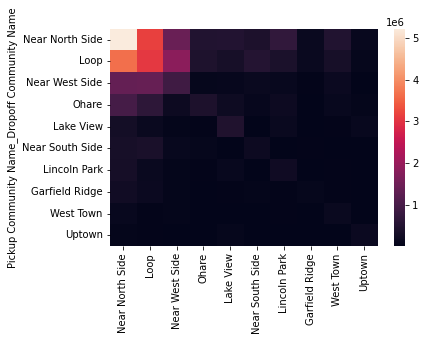

In [116]:
sns.heatmap(df_taxi_heatmap)

In [14]:
df_taxi.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: timestamp (nullable = true)
 |-- Trip End Timestamp: timestamp (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Community Name: string (nullable = true)
 |-- Dropoff Community Name: string (nullable = true)
 |-- Ride Month: integer (nullable = true)
 |-- Ride Year: integer (nullable = true)
 |-- Ride Day of Week: integer (nullable = true)
 |-- Ride Date: date (nullable = true)
 |-- Ride Month Year: string (nullable = false)



### Some exploratory analysis of how rides are trending over time

#### Month over month analysis

In [14]:
tmp_yoy = df_taxi.groupby('Ride Year').count().toPandas()

In [15]:
tmp_yoy = tmp_yoy.sort_values('Ride Year')

In [16]:
trip_ym = df_taxi.groupBy(col("Ride Month Year")).count().withColumnRenamed("count", "trips").toPandas()

In [17]:
trip_ym = trip_ym.sort_values('Ride Month Year')
trip_ym = trip_ym.set_index(trip_ym['Ride Month Year'])

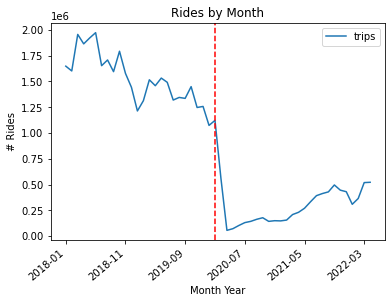

In [19]:
trip_ym[trip_ym['Ride Month Year'] != '2022-05'].plot()
plt.xlabel('Month Year')
plt.ylabel('# Rides')
plt.title('Rides by Month')
plt.xticks(rotation = 40, ha = 'right')
plt.axvline(25, linestyle = '--', c = 'r')

plt.show()

#### YoY Analysis

In [19]:
yoy_trip  = df_taxi.groupBy('Ride Year', 'Ride Month').count().orderBy(["Ride Year", "Ride Month"], ascending=[0, 0])
pdf = yoy_trip.toPandas()
pdf = pdf.pivot(index='Ride Month', columns='Ride Year', values='count')

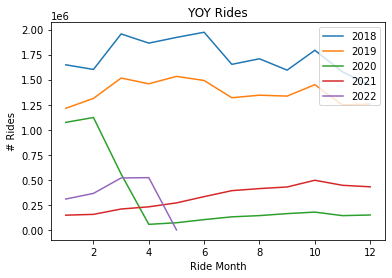

In [20]:
pdf.plot()
plt.xlabel('Ride Month')
plt.ylabel('# Rides')
plt.title('YOY Rides')
plt.legend(loc = 1)
plt.show()

#### How ride lengths are trending over time

In [22]:
df_taxi = df_taxi.withColumn("trip_minutes", col("Trip Seconds")/60)
trip_minutes_daily = df_taxi.groupBy("Ride Date").mean("trip_minutes").withColumnRenamed("avg(trip_minutes)", "avg_minutes")

In [22]:
pdf = trip_minutes_daily.toPandas()

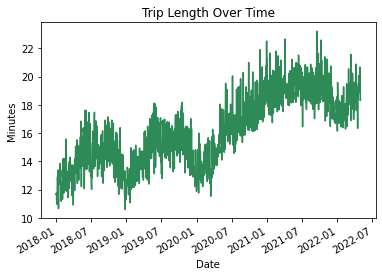

In [24]:
pdf = pdf.set_index(pd.to_datetime(pdf['Ride Date']))
pdf.plot(legend = None, c = 'seagreen')
plt.title('Trip Length Over Time')
plt.xlabel('Date')
plt.ylabel('Minutes')
plt.show()

#### Common Trip Times

In [16]:
df_taxi = df_taxi.withColumn('hour', F.date_format("Trip Start Timestamp", 'HH'))

In [17]:
hour_trip = df_taxi.groupBy(col("hour")).count().withColumnRenamed("count", "trips").orderBy("count", ascending=False)
pdf = hour_trip.toPandas()

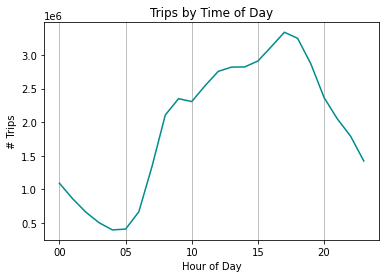

In [21]:
pdf = pdf.sort_values('hour')
x = pdf.hour
pdf.plot(x='hour', y='trips', legend = None, c = 'darkcyan' )
plt.xlabel('Hour of Day')
plt.ylabel('# Trips')
plt.title('Trips by Time of Day')
plt.grid(axis = 'x', )
plt.show()

In [29]:
dow_trip = df_taxi.groupBy(col("Ride Day of Week")).count().withColumnRenamed("count", "trips").orderBy("count", ascending=False)
pdf = dow_trip.toPandas()

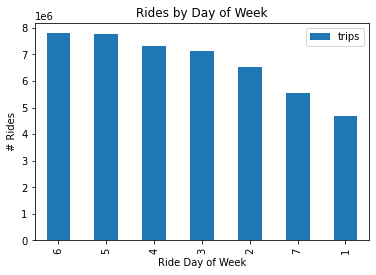

In [36]:
pdf.plot(kind= 'bar', y='trips', x='Ride Day of Week')
plt.title('Rides by Day of Week')
plt.ylabel('# Rides')
plt.show()